In [2]:
# carga el dataset
import numpy as np
import pandas as pd

df_restaurants = pd.read_csv('./data/restaurants.csv', delimiter=',', decimal='.', encoding='UTF-8')
df_restaurants.head()

,id,name,tag,x,y,district,IDDIST,direction,stars,n_reviews,min_price,max_price,platform
0,71036,Restaurante Statera,$$$$||Peruana||contemporánea||Opciones sin glu...,-12.115658,-77.043440,MIRAFLORES,150122,"Avenida Mariscal La Mar 463, Miraflores, Lima ...",50,130,80.0,280.0,tripadvisor
1,72471,Maras Restaurante,$$$$||Peruana||Latina||Internacional||,-12.092106,-77.024660,SAN ISIDRO,150131,Amador Merino Reyna 551 Esquina Calle Begonias...,45,675,158.0,237.0,tripadvisor
2,29667,Ventarrón Restaurante Chiclayano & Barra,$$ - $$$||Peruana||Mariscos||Gastropub||,-12.149373,-77.020706,BARRANCO,150104,"Avenida Grau 276 Frente al Parque Municipal, L...",45,304,12.0,72.0,tripadvisor
3,144186,Aji 555 Real Thai Cuisine,$$ - $$$||Asiática||Tailandesa||Apto para vege...,-12.105918,-76.992340,SAN BORJA,150130,"Av. San Luis 2879 San Borja, Lima 41 Perú",45,361,20.0,83.0,tripadvisor
4,124291,Cebicheria La Mar,$$ - $$$||Peruana||Latina||Mariscos||,-12.113314,-77.045400,MIRAFLORES,150122,"Av. La Mar 770 Miraflores, Lima Perú",45,4864,79.0,99.0,tripadvisor


In [3]:
import re
import spacy
import pandas as pd

# Carga el modelo de spaCy para el idioma deseado
nlp = spacy.load("es_core_news_sm")  # Para español

def limpiar_texto(texto):
    texto_limpio = re.sub(r'-+|\$+', '', texto)
    return texto_limpio

def procesar_entidades(texto):
    # se dividie el texto en documentos usando "||" como delimitador
    texto_limpio = limpiar_texto(texto) 
    documentos = texto_limpio.split("||")
    # Se elimina elementos vacíos de la lista resultante y duplicados
    documentos = list(set([documento.strip() for documento in documentos if documento.strip()]))
    
    resultados = []  # Lista para almacenar los resultados
    
    # Procesa cada documento individualmente
    for documento in documentos:
        doc = nlp(documento)
        etiqueta = ""
        for entidad in doc.ents:
            etiqueta = entidad.label_
        
        resultados.append((documento, etiqueta))
    
    return resultados

# Obtener todos los tags únicos
todos_los_tags = set()
for tags in df_restaurants['tag']:
    tags_procesados = procesar_entidades(tags)
    todos_los_tags.update([tag for tag, _ in tags_procesados])

df_tags_unicos = pd.DataFrame({'tag': list(todos_los_tags)})

# Procesa cada tag único para obtener su tipo
df_tags_unicos['tipo_tag'] = df_tags_unicos['tag'].apply(lambda x: procesar_entidades(x)[0][1])
print(df_tags_unicos.head())

# Guarda el nuevo DataFrame en un archivo CSV si es necesario
df_tags_unicos.to_csv('./data/tags_unicos.csv', index=False)

print("grabo archivo")

                                  tag tipo_tag
0                      Hamburguesería      PER
1                                 Pub         
2                            Asiática      LOC
3                Cervecería artesanal         
4  Restaurante de cocina sudamericana         
grabo archivo


In [4]:
import numpy as np
import pandas as pd

df_tags = pd.read_csv('./data/tags_unicos.csv', delimiter=',', decimal='.', encoding='UTF-8')
df_tags.head()

,tag,tipo_tag
0,Hamburguesería,PER
1,Pub,NaN
2,Asiática,LOC
3,Cervecería artesanal,NaN
4,Restaurante de cocina sudamericana,NaN


In [5]:
df_tags = df_tags.dropna(subset=['tag'])

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


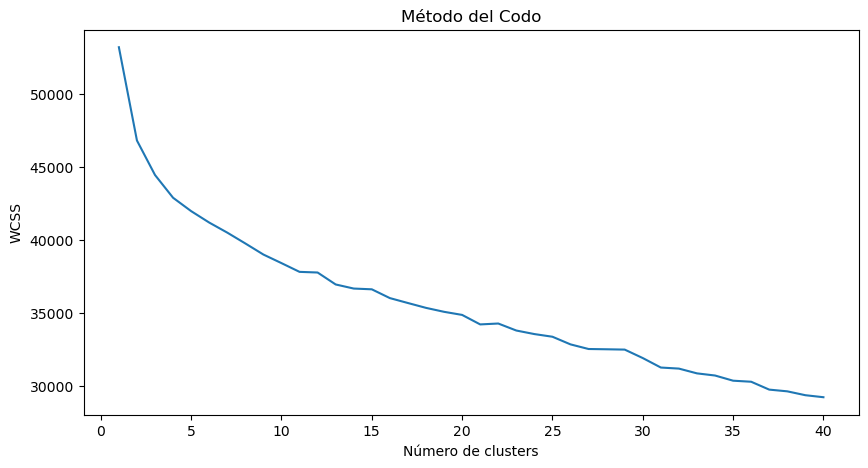

In [6]:
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import warnings
import os

# Suprime advertencias específicas
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

os.environ["OMP_NUM_THREADS"] = "2"

# Carga el modelo BETO y el tokenizador
tokenizer = AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased")
model = AutoModel.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased")

# Función para obtener embeddings de palabras
def get_word_embedding(word):
    inputs = tokenizer(word, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# Obtiene la lista única de tags del DataFrame
words = df_tags['tag'].unique().tolist()

# Obtiene embeddings para todas las palabras
embeddings = np.array([get_word_embedding(word) for word in words])

# Método del codo para determinar el número óptimo de clusters
wcss = []
max_clusters = 40  # Ajusta este valor según tus necesidades
for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(embeddings)
    wcss.append(kmeans.inertia_)

# Grafica el método del codo
plt.figure(figsize=(10, 5))
plt.plot(range(1, max_clusters + 1), wcss)
plt.title('Método del Codo')
plt.xlabel('Número de clusters')
plt.ylabel('WCSS')
plt.show()


In [7]:
n_clusters = 10  # Ajusta basado en el gráfico del método del codo

# Realiza clustering con K-means
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)

# Crea un DataFrame con los resultados
df_results = pd.DataFrame({
    'palabra': words,
    'cluster': cluster_labels
})

print(df_results)

# Calcula similitud entre palabras
similarity_matrix = cosine_similarity(embeddings)

# Encuentra las palabras más similares para cada palabra
for i, word in enumerate(words):
    similar_indices = similarity_matrix[i].argsort()[::-1][1:4]  # Top 3 más similares (excluyendo la propia palabra)
    similar_words = [words[idx] for idx in similar_indices]
 #  print(f"{word}: {', '.join(similar_words)}")

# Guarda los resultados
df_results.sort_values('cluster').to_csv('./data/tags_cluster.csv', index=False)

print("se grabo")

                                       palabra  cluster
0                               Hamburguesería        5
1                                          Pub        2
2                                     Asiática        2
3                         Cervecería artesanal        5
4           Restaurante de cocina sudamericana        1
..                                         ...      ...
255          Restaurante de comida continental        1
256  Restaurante especializado en cocina cajún        5
257                        Tienda de refrescos        9
258                     Organizador de eventos        9
259                               Bar de vinos        9

[260 rows x 2 columns]
se grabo


Coordenadas de los centroides de los clusters:
[[-0.03772692  0.01066757  0.2681737  ... -0.08052443  0.39657062
  -0.2280832 ]
 [ 0.6496053  -0.35441765 -0.02273072 ... -0.79574835  0.91029525
   0.2880909 ]
 [-0.45731768  0.17267022  0.22886361 ...  0.3565881   0.6898292
  -0.94725794]
 ...
 [-0.17214331 -0.17694566  0.43221068 ... -0.01208255  0.33185232
  -0.41011494]
 [ 0.17256472 -0.466227   -0.1637316  ... -1.0067065   1.0701005
   0.91187924]
 [ 0.16837525 -0.24881543  0.08187328 ... -0.5195142   0.34178698
   0.23520023]]


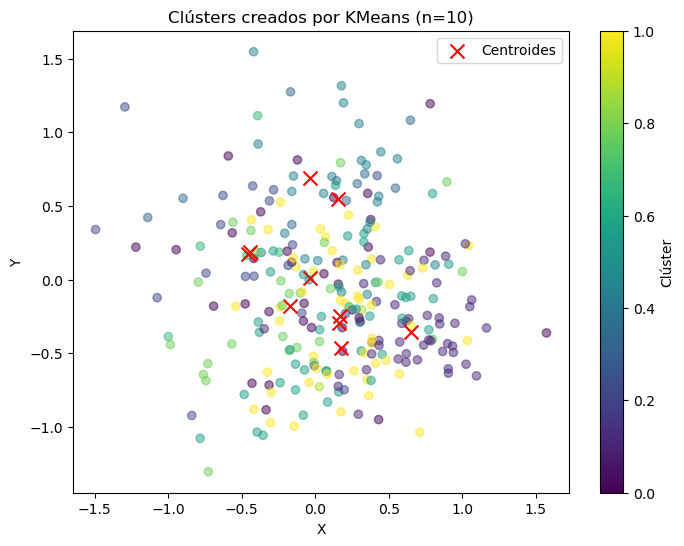

In [8]:
cluster_labels = kmeans.labels_
# Obtena las coordenadas de los centroides de los clusters
centroids = kmeans.cluster_centers_
print("Coordenadas de los centroides de los clusters:")
print(centroids)

# Visualiza los clústers
plt.figure(figsize=(8, 6))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=100, c='red', label='Centroides')
plt.title('Clústers creados por KMeans (n=10)')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.colorbar(label='Clúster')
plt.show()

In [2]:
import numpy as np
import pandas as pd

df_clusters = pd.read_csv('./data/tags_cluster.csv', delimiter=',', decimal='.', encoding='UTF-8')
df_clusters.head()

,palabra,cluster
0,Promotora inmobiliaria,0
1,Turoperador,0
2,Carnicería,0
3,Brasería,0
4,Copistería,0


cluster
9    49
1    46
5    43
0    33
4    28
7    26
2    18
3     9
6     6
8     2
Name: count, dtype: int64


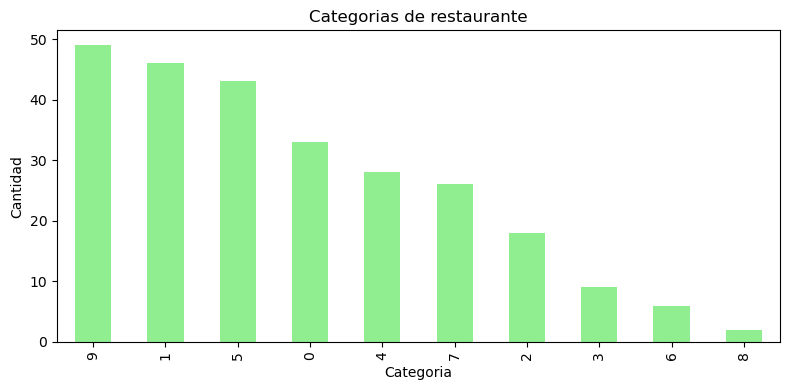

In [13]:
import matplotlib.pyplot as plt

valores = df_clusters['cluster'].value_counts()
print(valores)

# kind='barh',
plt.figure(figsize=(8, 4))
valores.plot(kind='bar', color='lightgreen')

plt.title('Categorias de restaurante')
plt.xlabel('Categoria')
plt.ylabel('Cantidad')

plt.tight_layout()
plt.show()